In [ ]:
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.signal import butter, filtfilt, decimate
from scipy.fft import fft, fftfreq
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, decimate
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks

def set_axis(x, no_labels=7) -> tuple:
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0, nx, step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels

def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

def plot_range(ts_start: str, ts_end: str):
    pack = get_range(ts_start, ts_end)
    df = pack["df"]

    # processing
    df = df - df.mean()
    df = np.abs(df)

    low, high = np.percentile(df, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    fig = plt.figure(figsize=(12, 16))
    ax = plt.axes()

    im = ax.imshow(df, aspect='auto', interpolation='none', norm=norm)

    ax.set_ylabel("time")
    ax.set_xlabel("space [m]")

    # Colorbar
    cax = fig.add_axes([
        ax.get_position().x1 + 0.06,
        ax.get_position().y0,
        0.02,
        ax.get_position().height
    ])
    plt.colorbar(im, cax=cax)

    # Axis ticks
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))

    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)

    plt.show()

def preprocess_signal(data, dt, lowcut=None, highcut=None, downsample_factor=None, standardize=True):
    processed = data.copy()
    
    # Bandpass filter
    if lowcut or highcut:
        nyq = 0.5 / dt
        low = lowcut / nyq if lowcut else None
        high = highcut / nyq if highcut else None
        
        if low and high:
            b, a = butter(4, [low, high], btype='band')
        elif low:
            b, a = butter(4, low, btype='high')
        elif high:
            b, a = butter(4, high, btype='low')
        processed = filtfilt(b, a, processed, axis=0)
    
    # Downsample
    if downsample_factor:
        processed = decimate(processed, downsample_factor, axis=0)
        # Update dt after downsampling
        dt = dt * downsample_factor
    
    # Standardization
    if standardize:
        processed = (processed - np.mean(processed, axis=0)) / np.std(processed, axis=0)
    
    return processed, dt
    
def frequency_analysis(ts_start: str, ts_end: str, lowcut=None, highcut=None, downsample_factor=None):
    pack = get_range(ts_start, ts_end)
    data = pack['data']
    dt = pack['dt']
    dx = pack['dx']
    
    # Preprocess data
    processed, dt_new = preprocess_signal(data, dt, lowcut=lowcut, highcut=highcut, 
                                          downsample_factor=downsample_factor)
    
    # Number of samples and channels
    n_samples, n_channels = processed.shape
    
    # Frequency axis
    freqs = fftfreq(n_samples, dt_new)
    
    # FFT for each channel
    fft_magnitudes = np.abs(fft(processed, axis=0))
    
    return freqs, fft_magnitudes, processed

def plot_fft(freqs, fft_magnitudes, channels=None, max_freq=None):
    n_channels = fft_magnitudes.shape[1]
    
    if channels is None:
        channels = range(min(5, n_channels))  # Plot first 5 channels by default
    
    plt.figure(figsize=(12, 6))
    for ch in channels:
        mag = fft_magnitudes[:, ch]
        # Only plot positive frequencies
        pos_mask = freqs >= 0
        if max_freq:
            pos_mask = pos_mask & (freqs <= max_freq)
        plt.plot(freqs[pos_mask], mag[pos_mask], label=f'Channel {ch}', alpha=0.7)
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.title('Frequency Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
def remove_static_background(df, window_size=50):
    background = df.rolling(window=window_size, axis=0, min_periods=1, center=True).median()
    return df - background

def enhance_contrast(df):
    arr = np.abs(df.values)
    p1, p99 = np.percentile(arr, [1, 99])
    arr = (arr - p1) / (p99 - p1 + 1e-10)
    arr = np.clip(arr, 0, 1)
    return arr

def extract_moving_objects(df, dt, window_size=50):
    df_moving = remove_static_background(df, window_size=window_size)
    arr = enhance_contrast(df_moving)
    return pd.DataFrame(arr, index=df.index, columns=df.columns)

def plot_moving_objects(ts_start, ts_end):
    pack = get_range(ts_start, ts_end)
    df = pack['df']
    dt = pack['dt']

    df_moving = extract_moving_objects(df, dt)

    fig, ax = plt.subplots(figsize=(12, 16))
    im = ax.imshow(df_moving.values, aspect='auto', interpolation='none', cmap='viridis')
    plt.colorbar(im, ax=ax, label='Amplitude')
    ax.set_xlabel('Space [m]')
    ax.set_ylabel('Time')
    plt.show()
    
def estimate_velocities(df_moving, dt, dx, low_thresh=0.1, high_thresh=0.3, 
                       sigma=2, num_peaks=20, min_angle=10, max_angle=170,
                       debug=False):
    """
    Estimate velocities from moving objects using Hough transform.
    
    Args:
        df_moving: DataFrame with moving objects
        dt: Time sampling interval
        dx: Space sampling interval
        low_thresh: Lower threshold for Canny edge detection
        high_thresh: Upper threshold for Canny edge detection
        sigma: Sigma for Canny edge detection
        num_peaks: Number of peaks to detect in Hough space
        min_angle: Minimum angle in degrees (to filter out horizontal lines)
        max_angle: Maximum angle in degrees (to filter out horizontal lines)
        debug: If True, plot edge detection and Hough space
    """
    arr = df_moving.values
    
    # Edge detection
    edges = canny(arr, sigma=sigma, low_threshold=low_thresh, high_threshold=high_thresh)
    
    if debug:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(arr, aspect='auto', cmap='viridis')
        axes[0].set_title('Moving Objects')
        axes[1].imshow(edges, aspect='auto', cmap='gray')
        axes[1].set_title('Edge Detection')
    
    # Hough transform
    h, theta, d = hough_line(edges)
    
    if debug:
        axes[2].imshow(np.log(1 + h), aspect='auto', cmap='hot')
        axes[2].set_title('Hough Space')
        axes[2].set_xlabel('Theta (angle)')
        axes[2].set_ylabel('Distance')
        plt.tight_layout()
        plt.show()
    
    # Find peaks
    hspace, angles, dists = hough_line_peaks(h, theta, d, num_peaks=num_peaks, 
                                             threshold=0.3*h.max())
    
    velocities = []
    angles_deg = []
    
    min_angle_rad = np.deg2rad(min_angle)
    max_angle_rad = np.deg2rad(max_angle)
    
    for _, angle, _ in zip(hspace, angles, dists):
        # Filter out nearly horizontal and vertical lines
        if min_angle_rad < angle < max_angle_rad:
            # Convert angle to slope
            # In image coordinates: angle is from horizontal axis
            # slope = -1/tan(angle) for x vs y plot
            # But we need dy/dx (time vs space)
            
            # For slanted lines in time-space plot:
            # angle is measured from horizontal (space axis)
            # slope_image = tan(angle) = dy/dx where y=time, x=space (in pixels)
            
            slope_pixels = np.tan(angle)  # pixels_time / pixels_space
            
            # Convert to physical units
            # slope_physical = (dt * pixels_time) / (dx * pixels_space)
            slope_physical = slope_pixels  # Already in pixel ratio
            
            # Velocity = distance/time = dx/dt * (1/slope_pixels)
            # Or: v = (pixels_space/pixels_time) * (dx/dt)
            
            if np.abs(slope_pixels) > 0.01:  # Avoid near-horizontal lines
                v = (dx / dt) / slope_pixels  # m/s
                velocities.append(v)
                angles_deg.append(np.rad2deg(angle))
    
    if debug:
        print(f"Found {len(velocities)} lines")
        print(f"Angles (deg): {angles_deg}")
        print(f"Raw velocities: {velocities}")
    
    # Group similar velocities
    velocities = np.array(velocities)
    if len(velocities) > 0:
        # Remove outliers (extremely high velocities are likely noise)
        reasonable_velocities = velocities[np.abs(velocities) < 1000]
        
        if len(reasonable_velocities) > 0:
            grouped = []
            velocities_sorted = np.sort(reasonable_velocities)
            
            # Adaptive grouping
            while len(velocities_sorted) > 0:
                ref = velocities_sorted[0]
                # Group within 10% of reference velocity or 20 m/s, whichever is larger
                tolerance = max(np.abs(ref) * 0.1, 20)
                group = velocities_sorted[np.abs(velocities_sorted - ref) < tolerance]
                grouped.append(np.mean(group))
                velocities_sorted = np.delete(velocities_sorted, 
                                             np.where(np.abs(velocities_sorted - ref) < tolerance))
            return grouped
        
    return []

def analyze_segment(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016, 
                   lowcut=1, highcut=100, downsample_factor=2):
    """
    Analyze a 2-minute segment of data.
    
    Args:
        ts_start: Start time in format 'HHMMSS'
        ts_end: End time in format 'HHMMSS'
        dx: Spatial sampling interval (m)
        dt: Temporal sampling interval (s)
        lowcut: Lower frequency cutoff for bandpass filter (Hz)
        highcut: Upper frequency cutoff for bandpass filter (Hz)
        downsample_factor: Factor by which to downsample the signal
    """
    # Load data
    pack = get_range(ts_start, ts_end, dx=dx, dt=dt)
    data = pack['data']
    df = pack['df']
    
    # Preprocess signal
    data_proc, dt_new = preprocess_signal(data, dt, lowcut=lowcut, highcut=highcut, 
                                          downsample_factor=downsample_factor)
    
    # Frequency analysis
    n_samples, n_channels = data_proc.shape
    freqs = fftfreq(n_samples, dt_new)
    fft_mags = np.abs(fft(data_proc, axis=0))
    
    # Extract moving objects
    df_moving = extract_moving_objects(df, dt)
    
    # Estimate velocities
    velocities = estimate_velocities(df_moving, dt, dx)
    
    return {
        "ts_start": ts_start,
        "ts_end": ts_end,
        "data": data,
        "data_proc": data_proc,
        "df": df,
        "df_moving": df_moving,
        "fft_freqs": freqs,
        "fft_mags": fft_mags,
        "velocities": velocities,
        "dt": dt,
        "dt_proc": dt_new,
        "dx": dx
    }

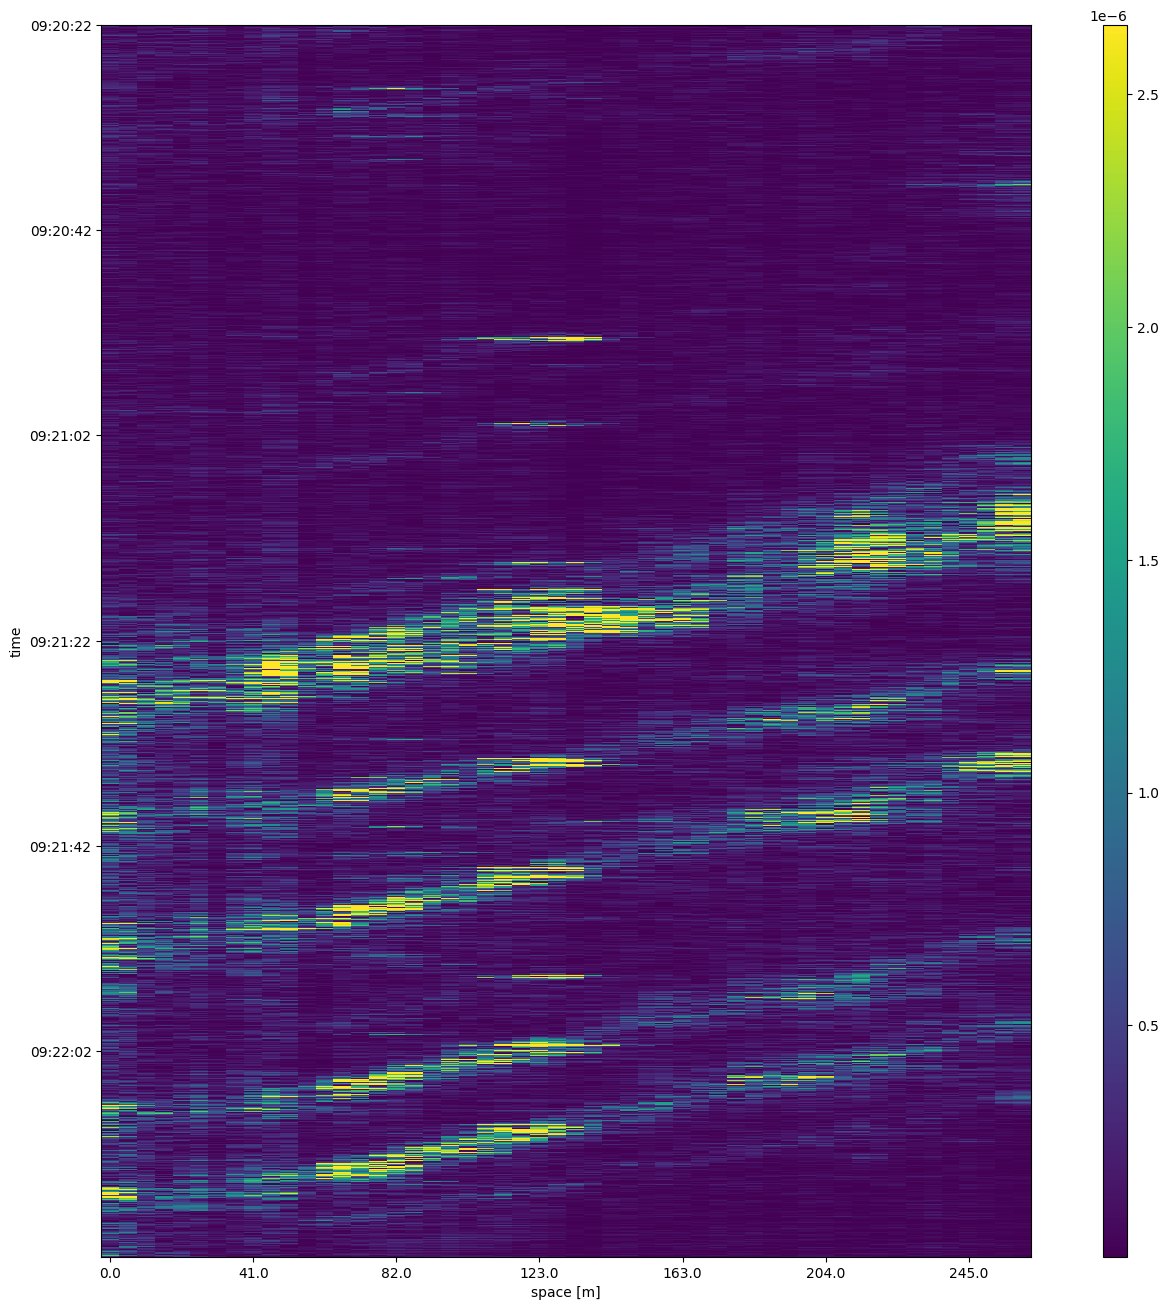

In [61]:
plot_range(range1[0], range1[1])
#plot_range(range2[0], range2[1])
#plot_range(range3[0], range3[1])

C:\Users\Piotrek\AppData\Local\Temp\ipykernel_20080\3925006365.py:160: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  background = df.rolling(window=window_size, axis=0, min_periods=1, center=True).median()


Estimated velocities (m/s): []


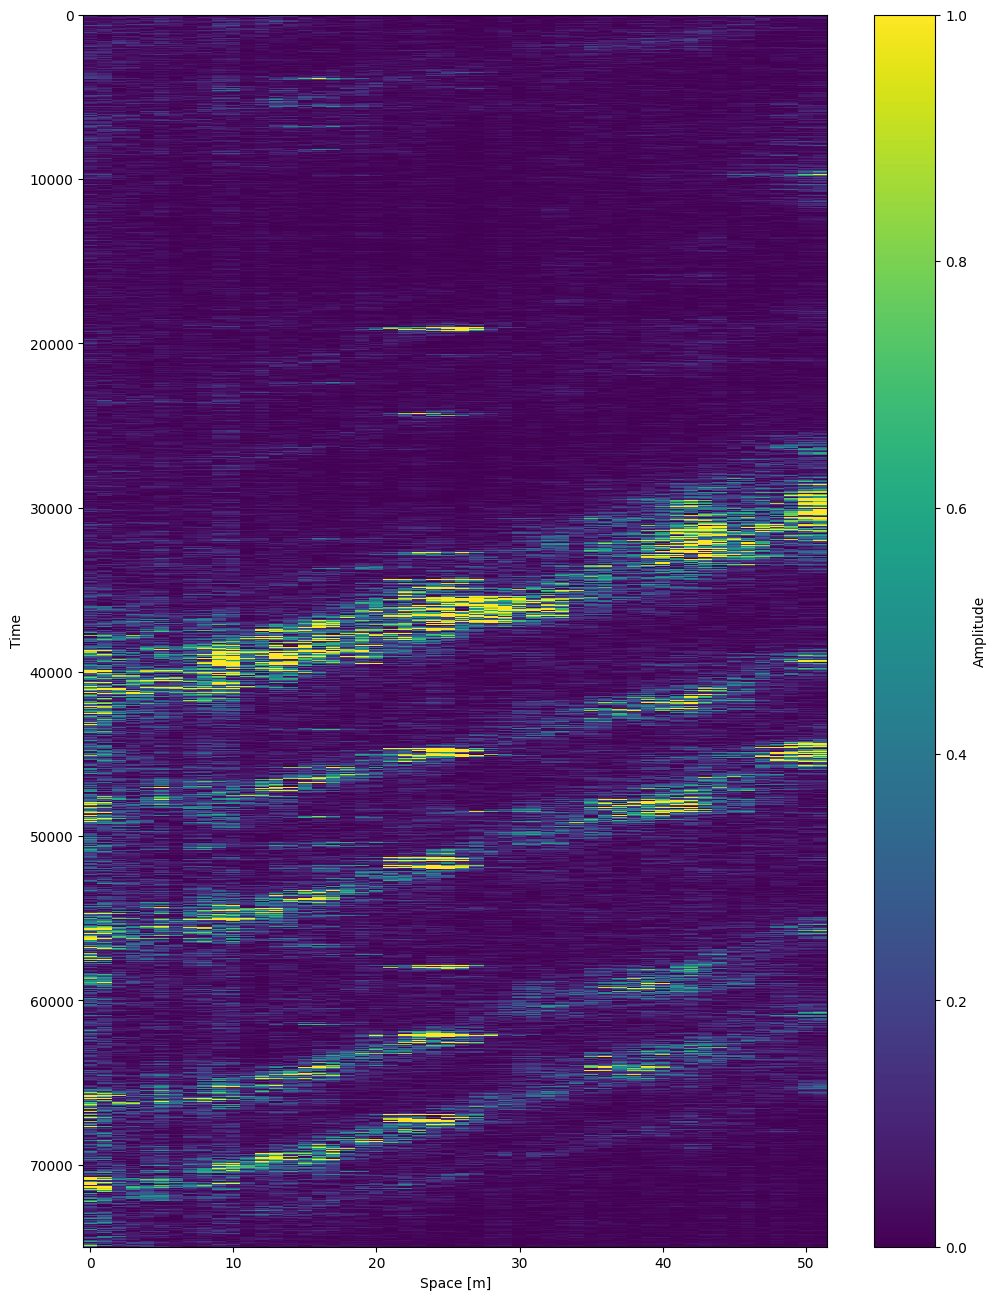

In [73]:
result = analyze_segment(range1[0], range1[1])
print("Estimated velocities (m/s):", result["velocities"])

plot_moving_objects(range1[0], range1[1])

